# Sentiment Analysis Using Supervised Machine Learning Models

##### José Luis Lobera del Castillo

In [132]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

### Loading the data

In [133]:
df = pd.read_csv('Datasets/Twitter Tweets/Tweets.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [134]:
print(df.columns)
df.describe()

Index(['textID', 'text', 'selected_text', 'sentiment'], dtype='object')


,textID,text,selected_text,sentiment
count,27482,27481,27481,27482
unique,27482,27481,22462,3
top,d620cbb8a9,I CAN`T!!! My heart aches for her children I...,good,neutral
freq,1,1,199,11118


In [135]:
def remove_punctuation(text):
    text = str(text)
    final = "".join(u for u in text if u not in ("?", ".", ";", ":", "!",'"', "'", "`"))
    return final

def to_lower(text):
    return text.lower()

### Data Analysis

In [136]:
from nltk.corpus import stopwords
from wordcloud import WordCloud 

stop_words = set(stopwords.words('english'))

In [137]:
df['selected_text'] = df['selected_text'].apply(remove_punctuation)
df['selected_text'] = df['selected_text'].apply(to_lower)

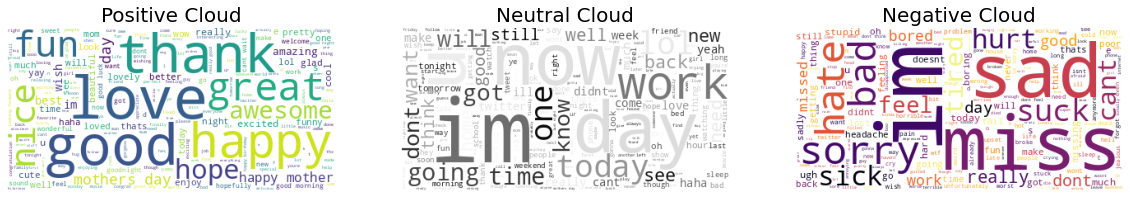

In [138]:
positiveText = " ".join(text for text in df['selected_text'][df['sentiment'] == 'positive'])
positiveCloud = WordCloud(background_color="white", colormap='viridis').generate(positiveText)

neutralText = " ".join(str(text) for text in df['selected_text'][df['sentiment'] == 'neutral'])
neutralCloud = WordCloud(background_color="white", colormap='gist_gray').generate(neutralText)

negativeText = " ".join(text for text in df['selected_text'][df['sentiment'] == 'negative'])
negativeCloud = WordCloud(background_color="white", colormap='inferno').generate(negativeText)

plt.figure(figsize=(20,15))

plt.subplot(1,3,1)
plt.title("Positive Cloud", fontsize=20)
plt.imshow(positiveCloud)
plt.axis("off")
plt.subplot(1,3,2)
plt.title("Neutral Cloud", fontsize=20)
plt.imshow(neutralCloud)
plt.axis("off")
plt.subplot(1,3,3)
plt.title("Negative Cloud", fontsize=20)
plt.imshow(negativeCloud)
plt.axis("off")

plt.show()

# Machine Learning

### Split Dataframe

In [139]:
X, Y = df['selected_text'], df['sentiment']

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=0)
print(testY.unique())

['negative' 'neutral' 'positive']


### Vectorize Strings

In [140]:
vec = TfidfVectorizer(min_df = 5, max_df = 0.8, sublinear_tf = True, use_idf = True)
train_vectors = vec.fit_transform(trainX.values.astype('U'))
test_vectors = vec.transform(testX.values.astype('U'))

## Naive Bayes

### Training

In [141]:
from sklearn.naive_bayes import MultinomialNB

NB_model = MultinomialNB(fit_prior=False)
NB_model.fit(train_vectors, trainY)

MultinomialNB(fit_prior=False)

### Predictions

In [142]:
predictions = NB_model.predict(test_vectors)

### Metrics

In [143]:
TAGS = ['Negative','Neutral','Positive']

In [144]:
def printConfussion(confussion):
    print("Confusion Matrix:")
    print(f"%12s" % (""), end=" ")
    
    for e in TAGS:
        print(f"%12s" % (e), end=" ")

    print("\n")

    i = 0
    for col in confussion:
        print(f"%12s" % (TAGS[i]), end=" ")
        for e in col:
            print(f"%12d" % (e), end=" ")
        print()
        i+=1

Score: 0.8078952155721303
Macro F1: 0.8050247563975163
Confusion Matrix:
                 Negative      Neutral     Positive 

    Negative         1196          182          169 
     Neutral          298         1929          224 
    Positive           63          120         1316 
Classification Report:
               precision    recall  f1-score   support

    negative       0.77      0.77      0.77      1547
     neutral       0.86      0.79      0.82      2451
    positive       0.77      0.88      0.82      1499

    accuracy                           0.81      5497
   macro avg       0.80      0.81      0.81      5497
weighted avg       0.81      0.81      0.81      5497



<AxesSubplot:>

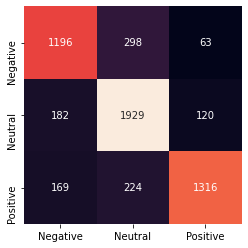

In [145]:
from sklearn.metrics import confusion_matrix,  classification_report


print("Score:", NB_model.score(test_vectors, testY))
print("Macro F1:", f1_score(predictions, testY, average='macro'))
cm = confusion_matrix(predictions,testY)
printConfussion(cm)

print("Classification Report:\n", classification_report(predictions,testY))

sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=TAGS, yticklabels=TAGS)

### Cross Validation

In [146]:
kf = KFold(n_splits=20, random_state=59, shuffle=True)

results = []
for train_idx, test_idx in kf.split(X):
    trainX, trainY = X[train_idx], Y[train_idx]
    testX, testY = X[test_idx], Y[test_idx]

    train_vectors = vec.fit_transform(trainX.values.astype('U'))
    test_vectors = vec.transform(testX.values.astype('U'))

    model = MultinomialNB(fit_prior=False)
    model.fit(train_vectors, trainY)
    predY = model.predict(test_vectors)

    results.append(f1_score(testY, predY, average='macro'))


In [147]:
print("Cross Validation Best Score:", max(results))

Cross Validation Best Score: 0.8207024517263739


## Logistic regression

### Training

In [148]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(max_iter=150)

LR_model.fit(train_vectors, trainY)

LogisticRegression(max_iter=150)

### Predictions

In [149]:
predictions = LR_model.predict(test_vectors)

### Metrics

Score: 0.8245997088791849
Macro F1: 0.8231064621874083
Confusion Matrix:
                 Negative      Neutral     Positive 

    Negative          311           45           43 
     Neutral           52          466           62 
    Positive           11           28          356 
Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.78      0.80       399
     neutral       0.86      0.80      0.83       580
    positive       0.77      0.90      0.83       395

    accuracy                           0.82      1374
   macro avg       0.82      0.83      0.82      1374
weighted avg       0.83      0.82      0.82      1374



<AxesSubplot:>

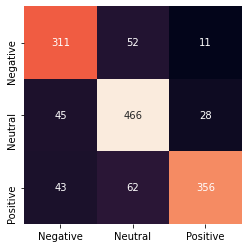

In [150]:
print("Score:", LR_model.score(test_vectors, testY))
print("Macro F1:", f1_score(predictions, testY, average='macro'))
cm = confusion_matrix(predictions, testY)
printConfussion(cm)

print("Classification Report:\n", classification_report(predictions, testY))

sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=TAGS, yticklabels=TAGS)

### Cross validation

In [151]:
kf = KFold(n_splits=10, random_state=59, shuffle=True)

results = []
for train_idx, test_idx in kf.split(X):
    trainX, trainY = X[train_idx], Y[train_idx]
    testX, testY = X[test_idx], Y[test_idx]

    train_vectors = vec.fit_transform(trainX.values.astype('U'))
    test_vectors = vec.transform(testX.values.astype('U'))

    model = LogisticRegression(max_iter=150)
    model.fit(train_vectors, trainY)
    predY = model.predict(test_vectors)

    results.append(f1_score(testY, predY, average='macro'))

In [152]:
print("Cross Validation Best Score:", max(results))

Cross Validation Best Score: 0.8332813618089384


### Try it yourself!

In [153]:
def printProba(proba):
    for e in ['Negative', 'Neutral', 'Positive']:
        print(f"%13s" % (e), end=" ")

    print()

    for e in proba:
            print(f"%12.3f%%" % (e*100), end=" ")
    print()

Change the string sentence and run the code for a Sentiment Analysis

In [154]:
testTweet = vec.transform([remove_punctuation("I'm so mad at him".lower())])

In [155]:
NB_model = MultinomialNB(fit_prior=False)
NB_model.fit(train_vectors, trainY)

LR_model = LogisticRegression(max_iter=150)
LR_model.fit(train_vectors, trainY)

LogisticRegression(max_iter=150)

In [156]:
print("Naive Bayes:\t\t", NB_model.predict(testTweet)[0].upper())
printProba(NB_model.predict_proba(testTweet)[0])
print()
print("Logistic Regression:\t", LR_model.predict(testTweet)[0].upper())
printProba(LR_model.predict_proba(testTweet)[0])


Naive Bayes:		 NEGATIVE
     Negative       Neutral      Positive 
      72.658%       20.250%        7.092% 

Logistic Regression:	 NEGATIVE
     Negative       Neutral      Positive 
      60.074%       34.845%        5.081% 
